# Forecasting - bootstrapping

This notebook describes how to use [Chi2Fit](https://hex.pm/packages/chi2fit) for simple forecasting. This is illustrated for a team that takes up work items, exercises their expertise to complete the work. It shows one way for answering the questions:

* duration - how many iterations does it take to complete a certain number of items?
* completed items - how many items can be completed in a certain number of iterations?

This note addresses one type of error introduced by the data set.

The data set that is available always has a limited number of elements and represents an incomplete population from the (assumed) true distribution.

Boostrapping [[3]](#References) is a technique to estimate error due to having an incomplete distribution.

## Table of contents

* [Set-up](#Set-up)
* [Data and simulation set-up](#Data-and-simulation-set-up)
* [Simple forecast using the empirical data](#Simple-forecast-using-the-empirical-data)
* [Bootstrapping](#Bootstrapping)
* [Total Monte Carlo](#Total-Monte-Carlo)
* [References](#References)

## Set-up

In [1]:
alias Chi2fit.Utilities, as: U
alias Gnuplotlib, as: P

Gnuplotlib

## Data and simulation set-up

As an example consider the throughput of completed backlog items. At the end of a fixed time period we count the number of backlog items that a team completes. Partially completed items are excluded from the count.

The numbers corresponding to the most recent times are at the head of the list.

In [2]:
data = [3,3,4,4,7,5,1,11,5,6,3,6,6,5,4,10,4,5,8,2,4,12,5]

[3, 3, 4, 4, 7, 5, 1, 11, 5, 6, 3, 6, 6, 5, 4, 10, 4, 5, 8, 2, 4, 12, 5]

Other parameters that affect the forecasting are listed below. Please adjust to your needs.

In [3]:
# The size of the backlog, e.g. 100 backlog items
size = 100

# Number of iterations to use in the Monte Carlo
iterations = 1000

6

## Simple forecast using the empirical data

Using the (throughput) data we simulate an iteration by randomly drawing a number from the data. We do this repeatedly until the sum of the numbers equals or exceeds the size of the backlog. The number of draws needed to deplete the backlog is the estimate of many iterations it takes to complete all backlog items.

We just described 1 simulation or run. If we do this many times we will find a different number of iterations needed to finish all items. This gives an average and variation.

This procedure is also known as Monte Carlo and was first described in [[1]](#References). A gentle introduction to Monte Carlo simulations is given in [[2]](#References).

#### Error

Due to the uncertainty in the number of completed items per iteration, the simulation runs will give different results. One can calculate the average and variance of the results. The square root of the variance approximates the error in the estimate. Because it originates from the statistical variation in the throughput data, this erroris known as a _statistical error_.

#### Duration

Using the histogram data for the throughput we perform a Monte Carlo simulation to get an estimation for the number of iterations needed to deplete the backlog. Since for a large enough number of samples results of a Monte Carlo simulation approximate the normal distribution. This provides a range for the uncertainty of the number of iterations. We express this as a probability using percentages.

In [4]:
{avg,sd,all} = U.mc iterations, U.forecast_duration(data, size), collect_all?: true
U.display {avg,sd,:+}

50%    => 20.0 units
84%    => 22.0 units
97.5%  => 24.0 units
99.85% => 26.0 units


:ok

The interpretation is that in 50% of the (simulation) runs all items have been completed with 20 iterations. And in 84% of the runs this took 22 iterations. We expect that in 16% of the times it will take more than 22 iterations to complete all items.

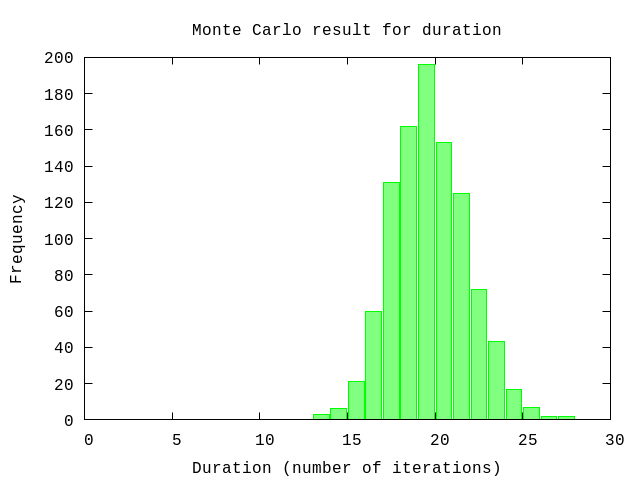

In [5]:
P.histogram(all,
    plottitle: "Monte Carlo result for duration",
    xlabel: "Duration (number of iterations)",
    ylabel: "Frequency",
    xrange: '[0:30]')
:"this is an inline image"

## Bootstrapping

In [6]:
fun = fn dat,_k -> U.mc(iterations, U.forecast_duration(dat, size)) end
boot = U.bootstrap(100, data, fun)

[{18.057, 2.1484298918047053}, {20.349, 1.6177759424592748}, {18.225, 1.9016768915880558}, {20.088, 2.0391802274443536}, {21.711, 2.5352473252130623}, {17.193, 1.8269512856121781}, {17.216, 2.144141786356497}, {17.706, 1.7508752097165556}, {17.55, 2.1277922830953178}, {17.007, 2.3492447722619305}, {23.572, 3.319761437212019}, {20.332, 2.4814866511831135}, {18.971, 1.9349829456612866}, {21.252, 2.079061326656818}, {19.864, 2.629354293357961}, {19.419, 2.6323827609221278}, {18.126, 2.23206720328936}, {16.728, 2.216757993106147}, {16.001, 1.5436965375357927}, {19.286, 2.219054753718351}, {15.933, 2.2078294771109355}, {19.733, 1.926061006302765}, {18.191, 1.6045307725313396}, {20.916, 1.9096973582219747}, {19.163, 2.412142408731281}, {18.16, 2.1039011383617776}, {18.878, 1.724852457458321}, {18.99, 1.7714118662806857}, {16.448, 1.88130167703109}, {16.683, 1.8543222481542827}, {18.131, 2.855142553358771}, {20.501, 2.298695064596435}, {18.067, 1.9966249021786615}, {22.284, 2.377255560515107}

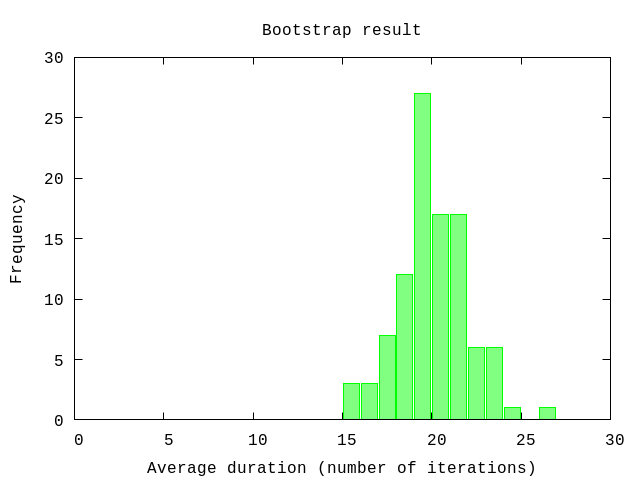

In [7]:
list = boot |> Enum.map(&elem(&1,0))
P.histogram(list,
    plottitle: "Bootstrap result",
    xlabel: "Average duration (number of iterations)",
    ylabel: "Frequency",
    xrange: '[0:30]')
:"this is an inline image"

In [8]:
# The average of the bootstrap results
avg_boot = U.moment(list,1)

# The error (standard deviation) as a result from the bootstrap
sd_boot = :math.sqrt U.momentc(list,2,avg_boot)

U.display {avg_boot,sd_boot,:+}

50%    => 20.0 units
84%    => 22.0 units
97.5%  => 24.0 units
99.85% => 25.0 units


:ok

This error is of a different nature than the _statistical error_ determined above and is known as a _systematic error_. It is custom to report these separately where the first number between parenthese refers to the _statistical error_ and the second number between brackets refers to the _systematic error_.

```
duration = 20.0 (+/- 2.0) (+/- 2.0) iterations
```

As an approximation one can (try to) combine the two by quadratically adding them as shown below.

__Note__: Strictly this is not correct because it assumes that both errors are Gaussian (normally) distributed which is in general not true for _systematic errors_.

In [9]:
sd_total = :math.sqrt sd*sd + sd_boot*sd_boot
U.display {avg, sd_total, :+}

50%    => 20.0 units
84%    => 23.0 units
97.5%  => 26.0 units
99.85% => 28.0 units


:ok

## References

[1] Metropolis, N.; Ulam, S. (1949). "The Monte Carlo Method". Journal of the American Statistical Association. 44 (247): 335–341.

[2] Kroese, D. P.; Taimre, T.; Botev, Z.I. (2011). Handbook of Monte Carlo Methods. New York: John Wiley & Sons. p. 772. ISBN 978-0-470-17793-8.

[3] Bootstrapping, http://t-redactyl.io/blog/2015/09/a-gentle-introduction-to-bootstrapping.html